In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


^C


In [2]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [72]:
image_size = (180, 180)
batch_size = 32

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "ChatChien",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "ChatChien",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

ValueError: `subset` must be either "training" or "validation", received: both

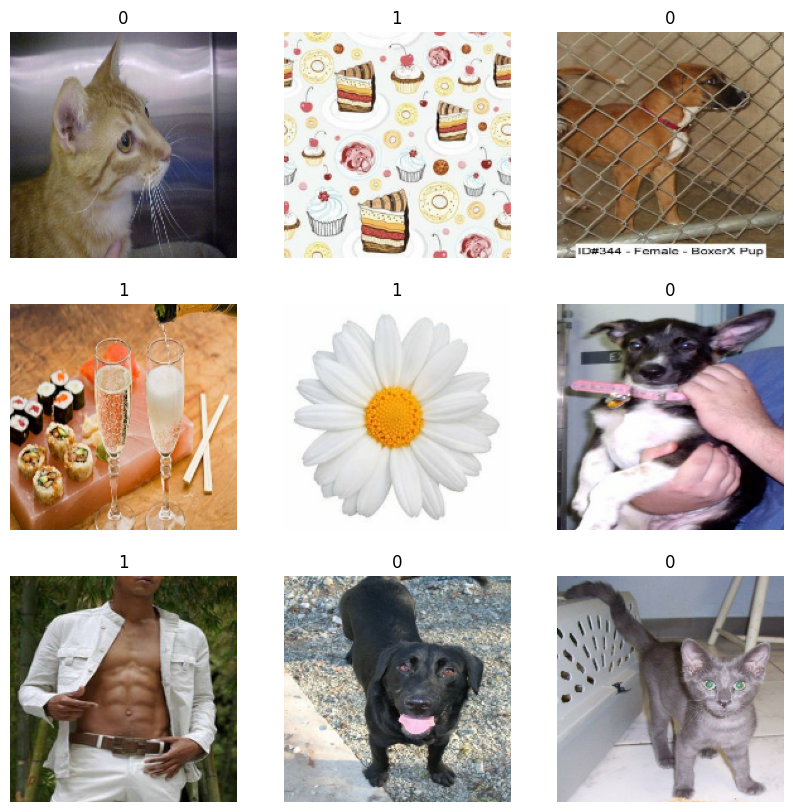

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [39]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

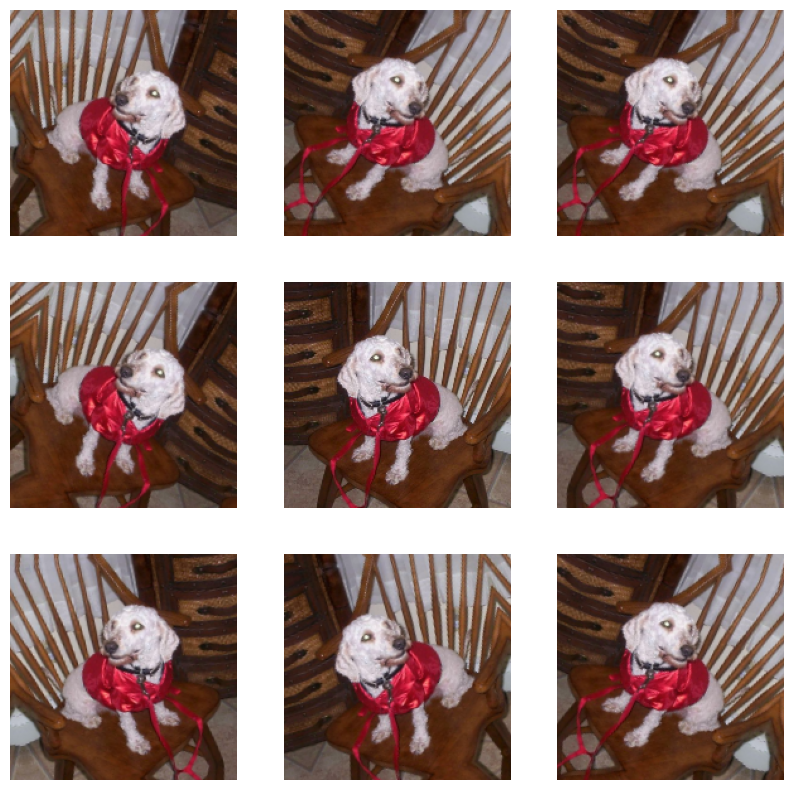

In [40]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [41]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

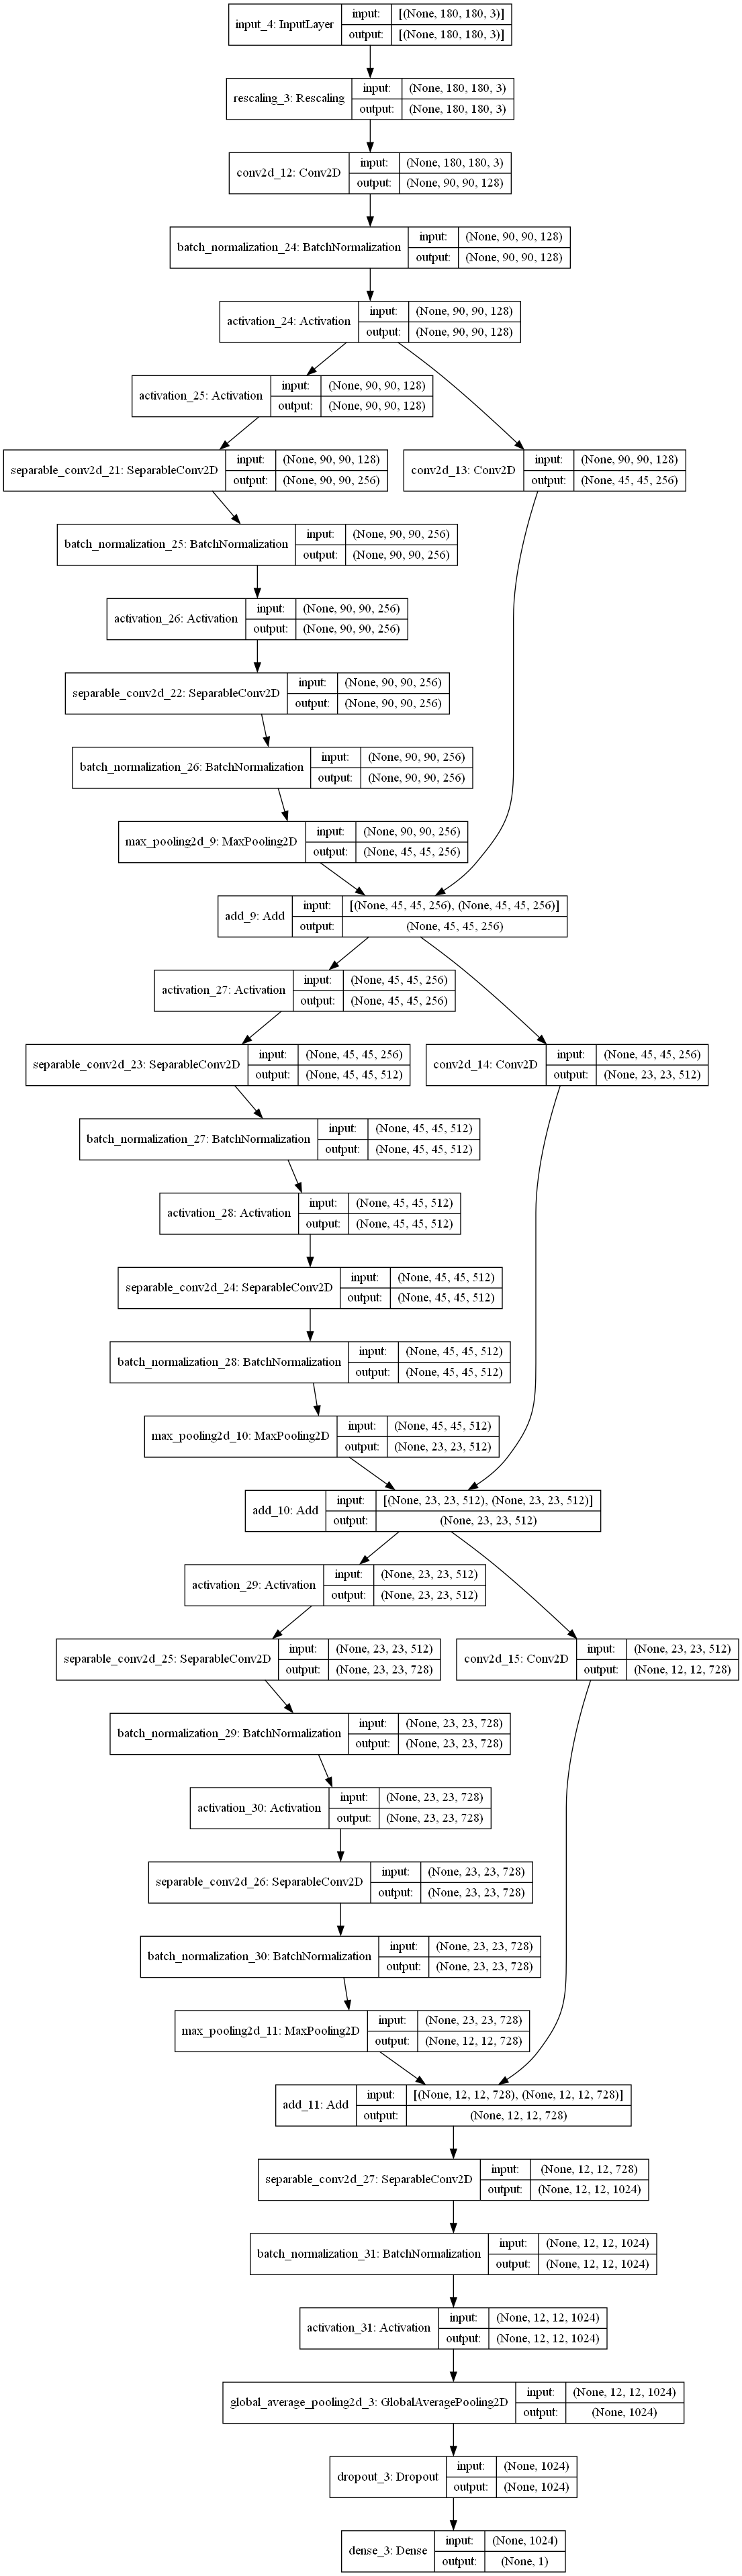

In [42]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [46]:
epochs = 40

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/40
21/21 [==============================] - 13s 543ms/step - loss: 0.2893 - accuracy: 0.8896 - val_loss: 0.6779 - val_accuracy: 0.5309
Epoch 2/40

C:\Users\natha\PycharmProjects\pythonProject1\venv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '



21/21 [==============================] - 12s 547ms/step - loss: 0.2687 - accuracy: 0.8911 - val_loss: 0.6692 - val_accuracy: 0.5309
Epoch 3/40
21/21 [==============================] - 12s 572ms/step - loss: 0.2410 - accuracy: 0.8942 - val_loss: 0.6632 - val_accuracy: 0.5309
Epoch 4/40
21/21 [==============================] - 12s 570ms/step - loss: 0.2651 - accuracy: 0.8972 - val_loss: 0.7266 - val_accuracy: 0.5309
Epoch 5/40
21/21 [==============================] - 11s 537ms/step - loss: 0.2822 - accuracy: 0.8880 - val_loss: 0.7089 - val_accuracy: 0.5062
Epoch 6/40
21/21 [==============================] - 11s 497ms/step - loss: 0.2376 - accuracy: 0.9064 - val_loss: 0.6713 - val_accuracy: 0.5309
Epoch 7/40
21/21 [==============================] - 11s 527ms/step - loss: 0.2200 - accuracy: 0.9064 - val_loss: 0.6516 - val_accuracy: 0.5309
Epoch 8/40
21/21 [==============================] - 11s 523ms/step - loss: 0.1908 - accuracy: 0.9310 - val_loss: 0.7091 - val_accuracy: 0.4383
Epoch 9/4

In [70]:
img = keras.preprocessing.image.load_img(
    "ztest/dog3.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% an animal and {100 * score:.2f}% an other thing.")

This image is 62.00% an animal and 38.00% an other thing.


In [71]:
model.save("./model")

INFO:tensorflow:Assets written to: ./model\assets


C:\Users\natha\PycharmProjects\pythonProject1\venv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1
